In [2]:
!pip3 install pandas

In [3]:
import pandas as pd

In [7]:
df = pd.read_csv("SpotifyFeatures.csv")
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [8]:
features = ['valence', 'energy', 'danceability', 'acousticness', 'tempo', 'loudness', 
    'speechiness', 
    'instrumentalness', 
    'liveness']

X = df[features]

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
from sklearn.cluster import KMeans

# Choose number of clusters (let's say 5 moods)
kmeans = KMeans(n_clusters=5, random_state=42)
df['mood_cluster'] = kmeans.fit_predict(X_scaled)

# Now each song is assigned to a "mood cluster"

In [11]:
cluster_summary = df.groupby('mood_cluster')[features].mean()
print(cluster_summary)

               valence    energy  danceability  acousticness       tempo  \
mood_cluster                                                               
0             0.336002  0.332763      0.506147      0.697375  111.752528   
1             0.640722  0.670030      0.704638      0.192694  108.926153   
2             0.155164  0.165379      0.292362      0.844025  102.478091   
3             0.414632  0.663503      0.562818      0.789351   98.023968   
4             0.430969  0.766319      0.503566      0.099973  142.572296   

               loudness  speechiness  instrumentalness  liveness  
mood_cluster                                                      
0            -12.008261     0.065861          0.066356  0.178686  
1             -7.041822     0.104922          0.059300  0.172583  
2            -20.922792     0.045696          0.740426  0.146678  
3            -11.988400     0.877456          0.001191  0.729090  
4             -5.947786     0.093683          0.091934  0.244200 

In [13]:
cluster_to_mood = {
    0: 'Happy Party',
    1: 'Sad Acoustic',
    2: 'Chill Vibes',
    3: 'Energetic',
    4: 'Mellow'
}

df['mood'] = df['mood_cluster'].map(cluster_to_mood)

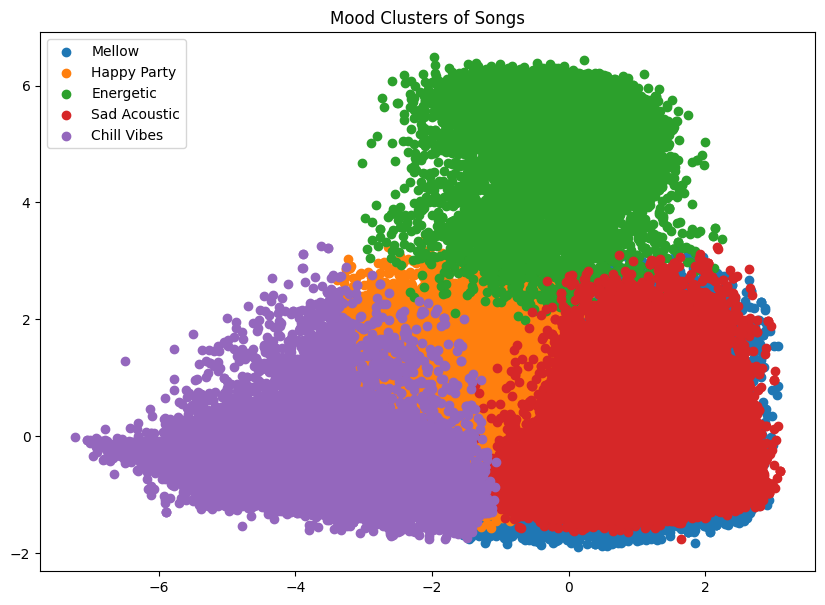

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

df['pca1'] = components[:, 0]
df['pca2'] = components[:, 1]

plt.figure(figsize=(10,7))
for mood in df['mood'].unique():
    subset = df[df['mood'] == mood]
    plt.scatter(subset['pca1'], subset['pca2'], label=mood)
    
plt.legend()
plt.title('Mood Clusters of Songs')
plt.show()